In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
!unzip -q gdrive/My\ Drive/Дорожные_знаки/data.zip -d data

In [0]:
# Установим размер классифицируемых изображений
PIC_SIZE = 50
# Путь к предобработанным данным
data_path = 'data/data//'
# Путь, куда сохраним модель
model_save_path = 'gdrive/My Drive/Дорожные_знаки'

In [41]:
import pandas as pd
import numpy as np
import torch
import os
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

print('Версия torch', torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(device))
else:
    print('Using CPU')

Версия torch 1.1.0
Tesla T4


In [0]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class SignsDataset(Dataset):
    """Road signs dataset."""

    def __init__(self, csv_file, root_dir, transform=None, no_labels=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.signs_frame = pd.read_csv(csv_file)
        print(f'{len(self.signs_frame)} samples loaded')
        
        self.root_dir = root_dir
        self.transform = transform
        self.no_labels = no_labels
        
        # В тестовом датасете нет ответов
        if not self.no_labels:
            # Cоздаём массив label->index и массив index->label
            self.labels = self.signs_frame['label'].unique()
            self.label_indexes = {}
            for i, label in enumerate(self.labels):
                self.label_indexes[label] = i

    def __len__(self):
        return len(self.signs_frame)

    def __getitem__(self, idx):
        # Загрузим изображение и приведём к размеру 50х50
        img_name = self.root_dir + self.signs_frame.iloc[idx, 0]
        image = Image.open(img_name)
        image = image.resize((PIC_SIZE, PIC_SIZE), Image.ANTIALIAS)
        
        # Применим преобразования изображения (например аугментацию)
        if self.transform:
            image = self.transform(image)
            
        # Для тестового датасета не нужны ответы
        if not self.no_labels:
            # В роли ответа будем давать номер label
            label_string = self.signs_frame.iloc[idx, 1]
            label = self.label_indexes[label_string]
        
            sample = {'image': image, 'label': label}
        else:
            sample = {'image': image}
            
        return sample

In [43]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Инициализируем загрузчик датасета (класс выше)
dataset = SignsDataset('gdrive/My Drive/Дорожные_знаки/train.csv', 
                       data_path, 
                       torchvision.transforms.ToTensor())

indicies = np.arange(len(dataset))

np.random.seed(0)
np.random.shuffle(indicies)

# Разбиение датасета на train и validation
train_sampler = SubsetRandomSampler(indicies[:int(len(dataset)*0.5)])
validation_sampler = SubsetRandomSampler(indicies[int(len(dataset)*0.5):])

# DataLoader достаёт данные из dataset батчами
signsTrainLoader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
signsValidationLoader = DataLoader(dataset, batch_size=32, sampler=validation_sampler)

2503 samples loaded


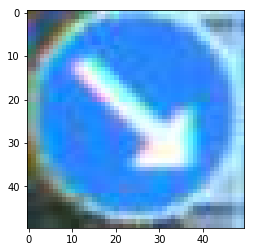

In [7]:
# Посмотрим, что выдаёт одна итерация DataLoader
batch = next(iter(signsTrainLoader))
img = batch['image'][0]
img = np.transpose(img, (1, 2, 0))

plt.imshow(img)

In [44]:
#Проверяем сбалансированность данных
df = dataset.signs_frame
classes_number = df['label'].nunique()
print('Classes number:', classes_number)
df.groupby('label')['file_name'].nunique()

Classes number: 17


label
100_SIGN                    62
110_SIGN                    18
30_SIGN                     30
50_SIGN                    118
60_SIGN                     19
70_SIGN                    150
80_SIGN                     61
90_SIGN                     16
GIVE_WAY                   143
NO_PARKING                  45
NO_STOPPING_NO_STANDING     51
OTHER                      322
PASS_EITHER_SIDE            19
PASS_RIGHT_SIDE            364
PEDESTRIAN_CROSSING        630
PRIORITY_ROAD              438
STOP                        17
Name: file_name, dtype: int64

In [0]:
#Создаём нейронную сеть здесь

In [0]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [0]:
# Класс свёрточной нейронной сети
class SimpleConvNet(nn.Module):
    def __init__(self, class_number):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 3),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        
        self.fc1 = nn.Linear(16 * 9 * 9, 120)  # !!! 
        
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, class_number)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Подаём картинку на вход и увидим, сколько элементов на входе первого fully connected!
        # Подробнее замечание снизу (оно из прошлого семинара)
        # print(x.shape)
        ## ИЛИ ЖЕ МОЖНО ЭТО РАССЧИТАТЬ, НО ЭТО ДОЛЬШЕ
        
        x = x.view(-1, 16 * 9 * 9)  # !!! Аналог Flatten в keras
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # Функция акктивации отсутствует
        # torch.nn.CrossEntropyLoss разбирается с этим сам
        return x

In [0]:
# Создаём сеть
cnn = SimpleConvNet(classes_number).to(device)

In [48]:
from tqdm import tqdm_notebook

# С помощью этого увидим, как сеть обучалась
history = {'loss':[], 'val_loss':[]}

# Выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# Выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

# Цикл обучения
i = 0
for epoch in tqdm_notebook(range(500)):

    running_loss = 0.0
    for batch in signsTrainLoader:
        
        # Так получаем текущий батч
        X_batch, y_batch = batch['image'].to(device), batch['label'].to(device)
        
        # Обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = cnn(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # Выведем текущий loss
        running_loss += loss.item()
        
        # Пишем в лог каждые 50 батчей
        if i % 50 == 49:
            batch = next(iter(signsValidationLoader))
            X_batch, y_batch = batch['image'].to(device), batch['label'].to(device)
            y_pred = cnn(X_batch)
            
            history['loss'].append(loss.item())
            history['val_loss'].append(loss_fn(y_pred, y_batch).item())
        
        # Выведем качество каждые 1000 батчей
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0
        i += 1

# Сохраним модель
#torch.save(cnn.state_dict(), model_save_path)
#print('Обучение закончено')

[13,  1000] loss: 0.0454
[26,  2000] loss: 0.0136
[38,  3000] loss: 0.0290
[51,  4000] loss: 0.0145
[64,  5000] loss: 0.0036
[76,  6000] loss: 0.0101
[89,  7000] loss: 0.0044
[102,  8000] loss: 0.0015
[114,  9000] loss: 0.0053
[127, 10000] loss: 0.0015
[140, 11000] loss: 0.0007
[152, 12000] loss: 0.0020
[165, 13000] loss: 0.0008
[178, 14000] loss: 0.0002
[190, 15000] loss: 0.0008
[203, 16000] loss: 0.0004
[216, 17000] loss: 0.0001
[228, 18000] loss: 0.0005
[241, 19000] loss: 0.0028
[254, 20000] loss: 0.0000
[266, 21000] loss: 0.0004
[279, 22000] loss: 0.0002
[292, 23000] loss: 0.0000
[304, 24000] loss: 0.0003
[317, 25000] loss: 0.0002
[330, 26000] loss: 0.0000
[342, 27000] loss: 0.0003
[355, 28000] loss: 0.0001
[368, 29000] loss: 0.0000
[380, 30000] loss: 0.0054
[393, 31000] loss: 0.0000
[406, 32000] loss: 0.0000
[418, 33000] loss: 0.0001
[431, 34000] loss: 0.0000
[444, 35000] loss: 0.0000
[456, 36000] loss: 0.0001
[469, 37000] loss: 0.0000
[482, 38000] loss: 0.0000
[494, 39000] loss: 

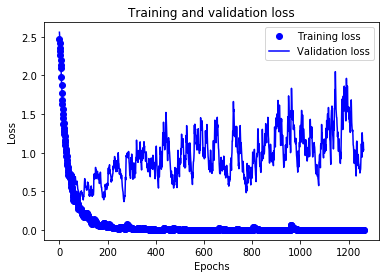

In [49]:
#Проверим процесс обучения
# Скользящее среднее
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.clf()
loss_values = smooth_curve(history['loss'])
val_loss_values = smooth_curve(history['val_loss'])
epochs = np.arange(len(loss_values))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
import itertools
    
# Воспользуемся функцией из документации matplotlib, выводящей confusion matrix 
# Source https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = cm.T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure(figsize=(16,11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.tight_layout()
    plt.show()

Normalized confusion matrix


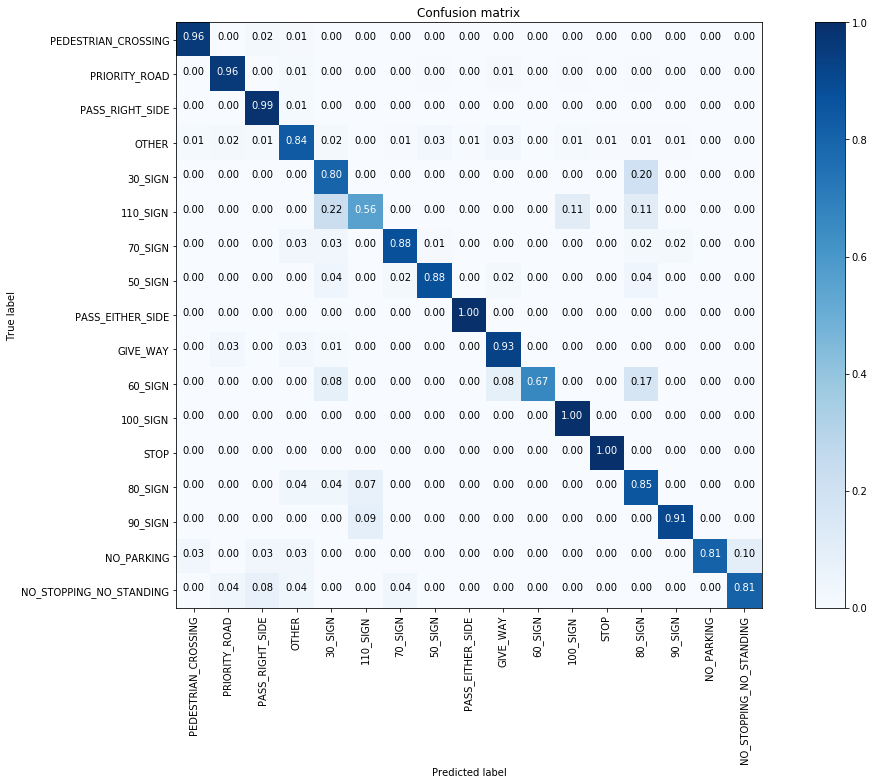

In [51]:
from sklearn.metrics import confusion_matrix

y_test_all = torch.Tensor().long()
predictions_all = torch.Tensor().long()

# Пройдём по всему validation датасету и запишем ответы сети
with torch.no_grad():
    for batch in signsValidationLoader:
        predictions = cnn(batch['image'].to(device))
        y_test = batch['label']
        _, predictions = torch.max(predictions.cpu(), 1)
        
        # Аналог append для list
        y_test_all = torch.cat((y_test_all, y_test), 0)
        predictions_all = torch.cat((predictions_all, predictions), 0)

feature_names = signsTrainLoader.dataset.labels

y_test_all = y_test_all.numpy()
predictions_all = predictions_all.numpy()

# Функция из sklearn, создаёт confusion матрицу
cm = confusion_matrix(y_test_all, predictions_all, np.arange(classes_number))
# Выведем её
plot_confusion_matrix(cm, dataset.labels, normalize=True)

In [52]:
#Выведем точность для каждого класса
class_correct = [0 for i in range(classes_number)]
class_total = [0 for i in range(classes_number)]

c = (predictions_all == y_test_all).squeeze()
for i in range(len(predictions_all)):
    label = predictions_all[i]            
    class_correct[label] += c[i].item()
    class_total[label] += 1

print(class_total)

for i in range(classes_number):
    print('Accuracy of %5s : %2d %%' % (
        (dataset.labels[i], (100 * class_correct[i] / class_total[i]) if class_total[i] != 0 else -1)))

[350, 209, 166, 155, 5, 9, 89, 48, 12, 69, 12, 27, 6, 27, 11, 31, 26]
Accuracy of PEDESTRIAN_CROSSING : 96 %
Accuracy of PRIORITY_ROAD : 96 %
Accuracy of PASS_RIGHT_SIDE : 98 %
Accuracy of OTHER : 83 %
Accuracy of 30_SIGN : 80 %
Accuracy of 110_SIGN : 55 %
Accuracy of 70_SIGN : 87 %
Accuracy of 50_SIGN : 87 %
Accuracy of PASS_EITHER_SIDE : 100 %
Accuracy of GIVE_WAY : 92 %
Accuracy of 60_SIGN : 66 %
Accuracy of 100_SIGN : 100 %
Accuracy of  STOP : 100 %
Accuracy of 80_SIGN : 85 %
Accuracy of 90_SIGN : 90 %
Accuracy of NO_PARKING : 80 %
Accuracy of NO_STOPPING_NO_STANDING : 80 %


In [53]:
#Создаём файл с предсказаниями
from torch.utils.data import DataLoader

# Инициализируем загрузчик датасета (класс выше)
test_dataset = SignsDataset('gdrive/My Drive/Дорожные_знаки/test.csv', 
                       data_path, 
                       torchvision.transforms.ToTensor(),
                       no_labels=True)


# DataLoader достаёт данные из dataset батчами
signsTestLoader = DataLoader(test_dataset, batch_size=1)

answer = []

for batch in signsTestLoader:
    predictions = cnn(batch['image'].to(device))
    _, predictions = torch.max(predictions, 1)
    answer.append(dataset.labels[predictions[0]])    

prediction_df = test_dataset.signs_frame
    
prediction_df['label'] = pd.Series(answer)
prediction_df.to_csv('gdrive/My Drive/Дорожные_знаки/my_road_sub1.csv', index=False)

610 samples loaded
